In [ ]:
#pip install all packages that will be imported below


# # This notebook was used to analyse phase contrast images of 3D cultures in https://doi.org/10.21203/rs.3.rs-3740673/v1 by Rodrigues et al

In [23]:
import pyclesperanto_prototype as cle 
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imshow
from skimage import filters
import pandas as pd
from skimage.filters.rank import median
from skimage.morphology import disk, ball, binary_dilation, binary_closing
from skimage.restoration import rolling_ball
from skimage.measure import label
from scipy.ndimage import binary_fill_holes
from napari_segment_blobs_and_things_with_membranes import split_touching_objects
import glob
import time
import re
from skimage.morphology import remove_small_objects
from skimage import measure


## Batch Analysis

In [25]:
# record start time
#make an array with file names in the folder
files = np.sort(glob.glob('/Users/bruni/AnaM/3D_phase_all_files/*ng*.tif'))
files
start = time.time()

properties =['area']
#make a list with the daframes
results = []

# for loop to process all images in the folder
for img in range(len(files)):
    images = imread(files[img])
    images = images[:,:,0]
#subtract background and gaussian filter
    
    background_rolling = rolling_ball(images, radius= 25)
    phase_rolling = images - background_rolling
   
    background_gaussian = filters.gaussian(phase_rolling, sigma=30, preserve_range=True)
    
            
#Image segmentation
    threshold = filters.threshold_minimum(background_gaussian)
    phase_binary = background_gaussian >= threshold
    filled = binary_fill_holes(phase_binary)
    split_objects = split_touching_objects(filled)
    
#https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects
#remove small objects
    removed_split = remove_small_objects(split_objects, 20000) 
#label images
    labeled_img = label(removed_split)
#remove objects on edges
    labels_excl_edges = cle.exclude_labels_on_edges(labeled_img)


   
   #Measure area

    data = measure.regionprops_table(
        label_image = labels_excl_edges,
        properties=properties)

# convert data to a table of measuments 


    df = pd.DataFrame(data)
      
#we need to get the ids of each image. Get this info from the file names.
#Get the replicate (n1 or n2, etc) and the 
    
    df['filename'] = files[img].split('\\')[-1]
    df['replicate'] = re.findall('(.*)_.*_.*g.*\.tif',files[img].split('\\')[-1])[0] #get replicates
    df['condition'] = re.findall('.*_(.*_.*g).*\.tif',files[img].split('\\')[-1])[0] #get conditions
   
    
    #append results - make a list of dfs
    results.append(df)
 #show result - if you have to many images -uncomment the code below
    #cle.imshow(label_image, labels=True)
    
#record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution is :", (end-start) , "s")

The time of execution is : 594.4952878952026 s


In [4]:

all_results = pd.concat(results)

pd.DataFrame.to_csv(all_results, '/Path/phase_contrast_quantification_Delta7_MST2_3D_final.csv')
all_results.tail()

NameError: name 'results' is not defined

In [5]:
import pandas as pd
all_results = pd.read_csv('/Path/phase_contrast_quantification_Delta7_MST2_3D_final.csv')

condition_counts = all_results['condition'].value_counts()

print(condition_counts)

d7_50ng    80
d7_0ng     75
ev_50ng    62
ev_0ng     60
fl_50ng    51
fl_0ng     34
Name: condition, dtype: int64


(0.0, 200000.0)

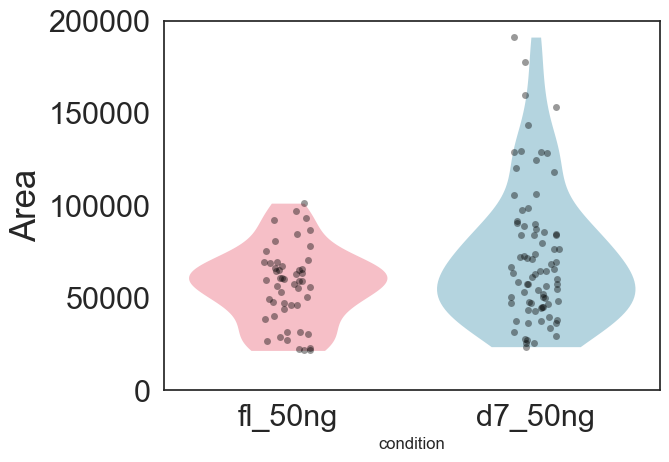

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter the data
df = all_results.query('condition != "ev_0ng" and condition != "ev_50ng" and condition != "fl_0ng" and condition != "d7_0ng"') 

# Define the order of conditions
condition_order = ["fl_50ng", "d7_50ng"]

# Define custom colors for the conditions
custom_palette = ["lightpink", "lightblue"]

# Set style and palette
sns.set(style="white", palette=custom_palette, color_codes=True)


# Create the violin plot without outlines
sns.violinplot(x="condition", y="area", data=df, inner=None, linewidth=0, scale="width", cut=0, alpha=0.1, order=condition_order)

# Overlay a swarm plot on top of the violin plot
sns.stripplot(x="condition", y="area", data=df, size=5, color="k", alpha=0.4, order=condition_order)

# Label the y-axis
plt.ylabel("Area", fontsize=25)  # Increase font size

# Increase font size of x-axis and y-axis labels
plt.xticks(fontsize=22)
plt.yticks(np.arange(0, 200500, 50000), fontsize=22)


# Set y-axis limits
plt.ylim(0, 200000)




In [8]:
# stats; T-test
from scipy import stats

# Extract data for each condition
fl_50ng_data = df[df['condition'] == 'fl_50ng']['area']
d7_50ng_data = df[df['condition'] == 'd7_50ng']['area']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(fl_50ng_data, d7_50ng_data)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -2.7483723063407295
P-Value: 0.006847997738739351
